<a href="https://colab.research.google.com/github/lafa-code/MachineLearning/blob/main/NormalitasData_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projek Stroke Detection- Cek distribusi data normal/tidak, jenis imputasi berdasar data normal/tidak untuk missing value, z score vs transformasi+z score, perbandingan
1. Ambil Dataset
2. Sambungkan ke Google Drive (jika perlu)
3. Baca Data → df
4. Cek struktur & tipe data
5. Cek missing value
    Jika ada: hapus
6. Cek distribusi data
    Normal/tidak (skewness, kurtosis, p-value, QQ Plot)
7. Jika tidak normal--> transformasikan misal pake log
a. beberapa algoritma butuh data normal/sensitif: logistic dan bayes baru Z score
b. Jika KNN, SVM, Tree based aman langsung ke Z-score saja
8. Lanjut ke modeling/eksperimen!
9. Split data</br>
10. evaluasi</br>
h. Modelling</br>
- ID3 </br>
- CART </br>
- Naive Bayes </br>
- SVM </br>
- KNN </br>
- Logistic regression </br>

Result:
bayes dan logistik ada perbedaan antara transformasi dan langsung z score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, skew, kurtosis
import statsmodels.api as sm

In [2]:
""" akses ke google drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Internal-2024/Missing_Data_stroke_ok.csv'
# file_path = '/content/drive/MyDrive/Internal-2024/Data_stroke.csv'

df = pd.read_csv(file_path)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [4]:
#Cek missing value
df.isnull().sum()

,0
gender,0
age,4
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,3
bmi,0
smoking_status,0


In [5]:
#Menampilkan informasi ringkas tentang struktur DataFrame df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4977 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4978 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [6]:
#hapus missing di 3 kolom num
df_clean = df.dropna(subset=['age', 'bmi', 'avg_glucose_level'])  #kolom numerik

#Cek missing value lagi
df_clean.isnull().sum()

#cek info lagi
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4975 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4975 non-null   object 
 1   age                4975 non-null   float64
 2   hypertension       4975 non-null   int64  
 3   heart_disease      4975 non-null   int64  
 4   ever_married       4975 non-null   object 
 5   work_type          4975 non-null   object 
 6   Residence_type     4975 non-null   object 
 7   avg_glucose_level  4975 non-null   float64
 8   bmi                4975 non-null   float64
 9   smoking_status     4975 non-null   object 
 10  stroke             4975 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 466.4+ KB


In [7]:
#1. DETEKSI AWAL
#bentuk normal/tidak

# 1. Normaitas bisa dicek posisi mean dan median (50%) (Age, glukose level, bmi)
# Jika mean ≈ median → kemungkinan distribusi simetris (mendekati normal)
# Jika mean > median → miring ke kanan (positif skew)
# Jika mean < median → miring ke kiri (negatif skew)
#2. Posisi mean ~ median, mean vs data max (avg_glukose)~outlier,
# mean jauhi std menjadi indikator ada outlier,namun tidak selalu distribusi tidak normal, std besar karena data variansi melebar (age)
df_clean.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000
mean,43.391622,0.095879,0.055276,105.922549,28.498452,0.048643
std,22.658362,0.294455,0.228542,45.034017,6.793538,0.215143
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.250000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.855000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [8]:
#CEK Skewness(kemiringan dari simetris) dan kurtosis (distribusi tajam dan memiliki banyak outlier, atau datar)
#skewness
#antara -0,5 dan 0,5, data menunjukkan simetri yang mendekati.
#-1 dan -0,5 (miring negatif) atau 0,5 dan 1 (miring positif) menunjukkan distribusi data yang sedikit miring.
# kurang dari -1 (miring negatif) atau lebih besar dari 1 (miring positif) dianggap sangat miring.

# Nilai Kurtosis	Jenis Distribusi	Karakteristik
# 0	Mesokurtic	Sama seperti normal (puncak & ekor standar)
# > 0 (positif)	Leptokurtic	Puncak tajam, ekor berat (banyak outlier)
# < 0 (negatif)	Platykurtic	Puncak datar, ekor ringan (lebih merata)

numeric_columns = ['age', 'avg_glucose_level','bmi']
# Loop untuk setiap kolom
for kolom in numeric_columns:
    print(f"\nStatistik untuk Kolom: {kolom}")
    print(f"Skewness : {skew(df_clean[kolom]):.4f}")
    print(f"Kurtosis : {kurtosis(df_clean[kolom]):.4f}")


# numeric_columns = ['age', 'avg_glucose_level', 'bmi']
# # Loop untuk setiap kolom
# for kolom in numeric_columns:
#     print(f"\n Statistik Deskriptif untuk Kolom: {kolom}")
#     print(f"Skewness (kemiringan): {skew(df[kolom].dropna()):.4f}")
#     print(f"Kurtosis: {kurtosis(df[kolom].dropna()):.4f}")


Statistik untuk Kolom: age
Skewness : -0.1427
Kurtosis : -0.9949

Statistik untuk Kolom: avg_glucose_level
Skewness : 1.5885
Kurtosis : 1.7587

Statistik untuk Kolom: bmi
Skewness : 0.3713
Kurtosis : -0.1414


In [9]:
#2 DETEKSI LEBIH DALAM DAN MENYELURUH
#simetri,puncak,ekor,sebaran,dan pola urutan data.

#pemisahan atribut
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married','work_type','Residence_type','smoking_status','stroke']
numeric_columns = ['age', 'avg_glucose_level', 'bmi']

# Loop untuk setiap kolom numerik
for kolom in numeric_columns:
    print(f"\n Uji Normalitas Shapiro-Wilk untuk Kolom: {kolom}")

    # Buang nilai kosong (NaN)
    data = df_clean[kolom].dropna()

    # Jalankan uji Shapiro-Wilk
    stat, p = shapiro(data)

    # Tampilkan hasil uji
    print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")
    if p > 0.05:
        print("Data kemungkinan berdistribusi normal (gagal tolak H0).")
    else:
        print("Data kemungkinan tidak normal (tolak H0).")


 Uji Normalitas Shapiro-Wilk untuk Kolom: age
Statistic: 0.9667, p-value: 0.0000
Data kemungkinan tidak normal (tolak H0).

 Uji Normalitas Shapiro-Wilk untuk Kolom: avg_glucose_level
Statistic: 0.8052, p-value: 0.0000
Data kemungkinan tidak normal (tolak H0).

 Uji Normalitas Shapiro-Wilk untuk Kolom: bmi
Statistic: 0.9874, p-value: 0.0000
Data kemungkinan tidak normal (tolak H0).


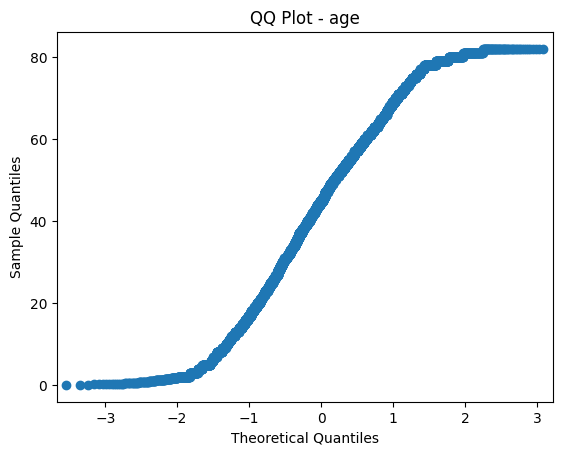

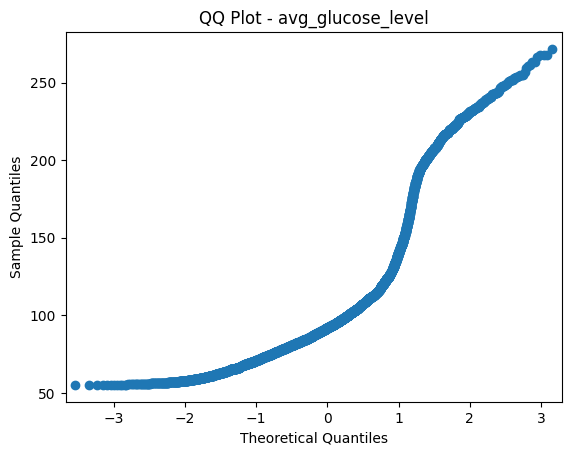

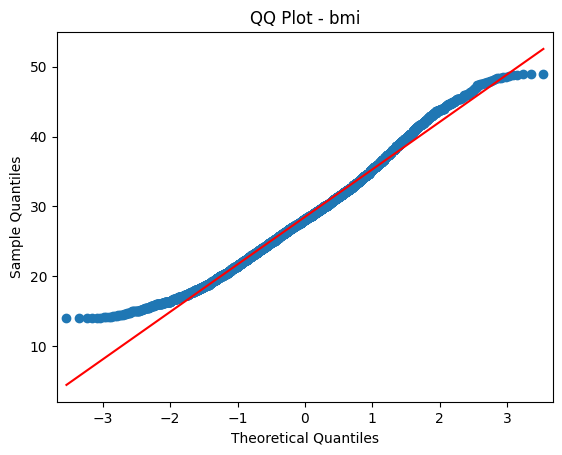

In [10]:
# 3. QQ Plot
# Daftar kolom numerik kontinu
numeric_columns = ['age', 'avg_glucose_level', 'bmi']

# Loop hanya untuk kolom tersebut
for kolom in numeric_columns:
    sm.qqplot(df[kolom], line='s')
    plt.title(f"QQ Plot - {kolom}")
    plt.show()

In [11]:
#Cek missing value dat awal untuk proses imputasi, dari uji normalitas pakai median
df.isnull().sum()

,0
gender,0
age,4
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,3
bmi,0
smoking_status,0


In [12]:
# Daftar kolom numerik kontinu
numeric_columns = ['age', 'avg_glucose_level', 'bmi']

# Imputasi missing value dengan median untuk setiap kolom
for kolom in numeric_columns:
    median_value = df[kolom].median()
    df[kolom].fillna(median_value, inplace=True)
    print(f"Missing value pada kolom '{kolom}' telah diisi dengan median: {median_value}")

Missing value pada kolom 'age' telah diisi dengan median: 45.0
Missing value pada kolom 'avg_glucose_level' telah diisi dengan median: 91.865
Missing value pada kolom 'bmi' telah diisi dengan median: 28.1


/tmp/ipython-input-12-2432765138.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[kolom].fillna(median_value, inplace=True)


In [13]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [14]:
# Konversi kolom kategoris ke tipe data kategori
df[categorical_columns] = df[categorical_columns].astype('category')

# encoding kategori ke integer
for col in categorical_columns:
    df[col] = df[col].cat.codes

In [15]:
""" pemisahan kolom label dengan kolom fitur """

features = df.iloc[:, :-1]  # semua kolom kecuali terakhir

labels = df.iloc[:, -1]  # Pilih kolom terakhir

feature_names = features.columns.tolist()

Pada bagian ini, kita akan diarahkan 2 Hal
1. Jika Algoritma Logistic Regression	dan Naives bayes, idealnya transformaikan ke normal data
2. Jika Decision tree, KNN, SVM, dia tangguh langsung ke normalisasi Z score saja



 Uji Normalitas Shapiro-Wilk untuk Kolom: age
Statistic: 0.7856, p-value: 0.0000
Data kemungkinan tidak normal (tolak H0).

 Uji Normalitas Shapiro-Wilk untuk Kolom: avg_glucose_level
Statistic: 0.9237, p-value: 0.0000
Data kemungkinan tidak normal (tolak H0).


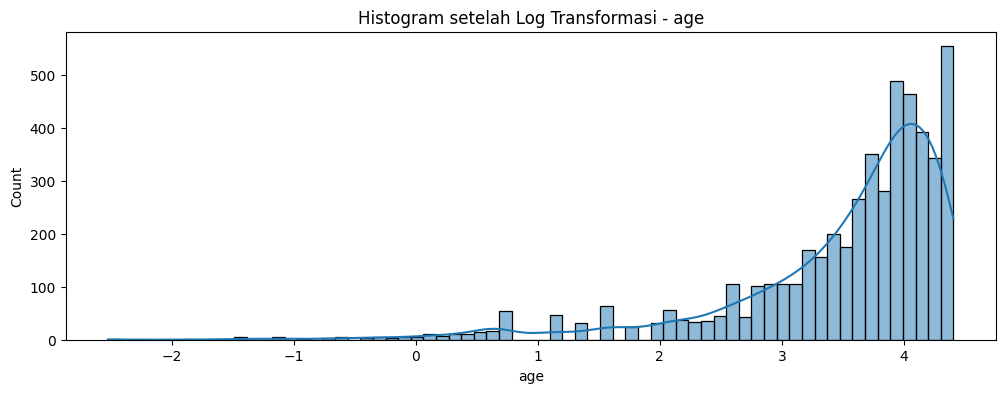

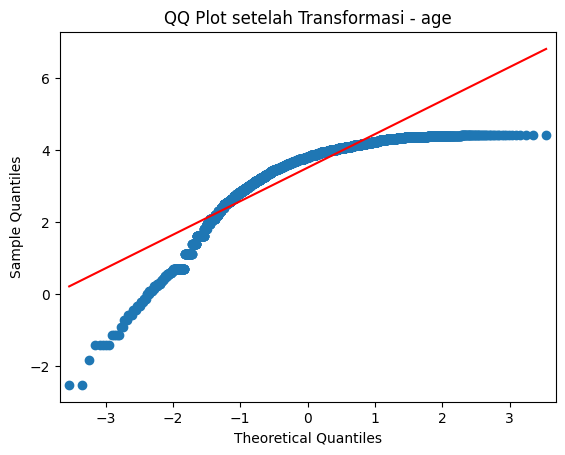

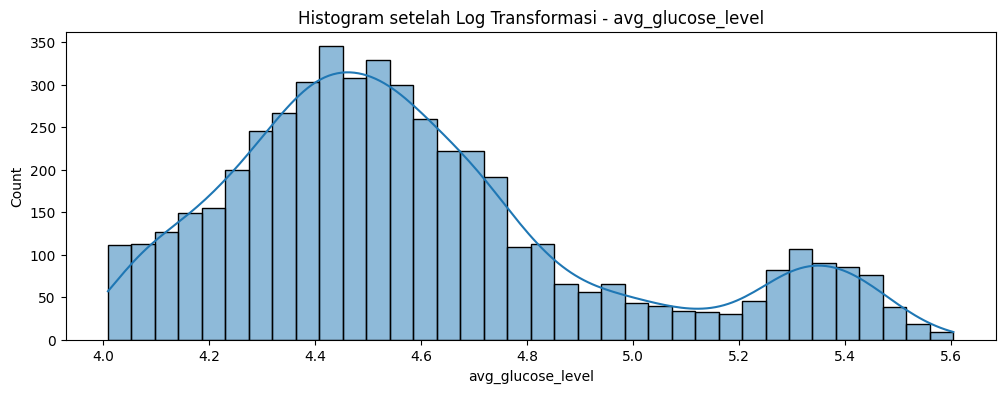

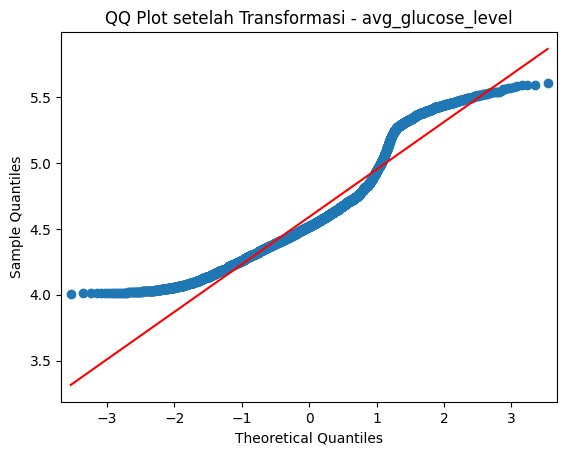

In [16]:
""" 1. KITA AKAN MELAKUKAN TRANSFORMASI DULU PAKE LOG KE 2 DATA TIDAK NORMAL kita"""
# Daftar kolom numerik yang akan ditransformasi
numeric_columns = ['age', 'avg_glucose_level']

# Buat salinan agar df asli tidak rusak
df_log = df.copy()

# Tambahkan 1 jika ada kemungkinan nilai 0 (misal: log(x+1))
for col in numeric_columns:
    if (df_log[col] <= 0).any():
        df_log[col] = np.log1p(df_log[col])  # log(x + 1)
    else:
        df_log[col] = np.log(df_log[col])    # log(x)


#2 DETEKSI LEBIH DALAM DAN MENYELURUH
#simetri,puncak,ekor,sebaran,dan pola urutan data.

#pemisahan atribut
numeric_columns = ['age', 'avg_glucose_level']

# Loop untuk setiap kolom numerik
for kolom in numeric_columns:
    print(f"\n Uji Normalitas Shapiro-Wilk untuk Kolom: {kolom}")

    # Buang nilai kosong (NaN)
    data = df_log[kolom].dropna()

    # Jalankan uji Shapiro-Wilk
    stat, p = shapiro(data)

    # Tampilkan hasil uji
    print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")
    if p > 0.05:
        print("Data kemungkinan berdistribusi normal (gagal tolak H0).")
    else:
        print("Data kemungkinan tidak normal (tolak H0).")


for kol in ['age', 'avg_glucose_level']:
    plt.figure(figsize=(12, 4))
    sns.histplot(df_log[kol], kde=True)
    plt.title(f"Histogram setelah Log Transformasi - {kol}")
    plt.show()

    sm.qqplot(df_log[kol], line='s')
    plt.title(f"QQ Plot setelah Transformasi - {kol}")
    plt.show()

In [17]:
numeric_columns = ['age', 'avg_glucose_level']
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                       'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Ambil semua fitur yang akan distandardisasi (semua kolom: numeric + encoded categorical)
features_all = df_log[numeric_columns + categorical_columns]

# Normalisasi Z-Score ke semua kolom (numeric & encoded categorical)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_z_array = scaler.fit_transform(features_all)

# Buat DataFrame hasilnya
features_z = pd.DataFrame(features_z_array, columns=features_all.columns)

# Simpan hasil akhir ke CSV
features_z.to_csv('/content/drive/MyDrive/Internal-2024/features_z.csv', index=False)



In [18]:
features_z

,age,avg_glucose_level,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
0,0.748012,2.333767,1.183909,-0.326186,4.136753,0.720137,-0.351534,0.983473,-0.353933,4.368601
1,0.938352,0.198424,1.183909,-0.326186,4.136753,0.720137,-0.351534,-1.016804,0.578840,4.368601
2,0.412193,1.530992,-0.844660,-0.326186,-0.241735,0.720137,-0.351534,0.983473,1.511613,4.368601
3,0.924850,1.577426,-0.844660,3.065738,-0.241735,0.720137,0.811143,-1.016804,0.578840,4.368601
4,0.951685,1.763667,1.183909,-0.326186,-0.241735,0.720137,-0.351534,0.983473,-0.353933,4.368601
...,...,...,...,...,...,...,...,...,...,...
4976,0.220872,-0.944728,1.183909,-0.326186,-0.241735,-1.388624,-0.351534,-1.016804,-0.353933,-0.228906
4977,0.194368,1.836308,1.183909,-0.326186,-0.241735,0.720137,-0.351534,0.983473,1.511613,-0.228906
4978,0.320789,-0.102858,-0.844660,3.065738,-0.241735,0.720137,-1.514212,-1.016804,1.511613,-0.228906
4979,0.194368,-0.446831,1.183909,-0.326186,-0.241735,0.720137,-0.351534,-1.016804,1.511613,-0.228906


In [19]:
"""Splitt data menjadi subset train dan test. Sebagai aturan praktis, rasio 80:20 untuk train dan test.
opsi lain Misalnya, 90:10, atau 70:30. """

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_z, labels, test_size=0.2, random_state=42)

In [24]:
# Membuat fungsi evaluasi model dan confusion matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


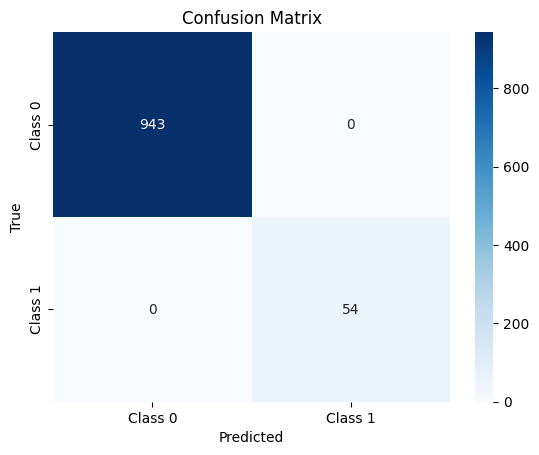

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model
logistic_regression = LogisticRegression()

# Train the model on the training data
logistic_regression.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)

# Calculate the accuracy of the model
evaluate_model(y_test, y_pred)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


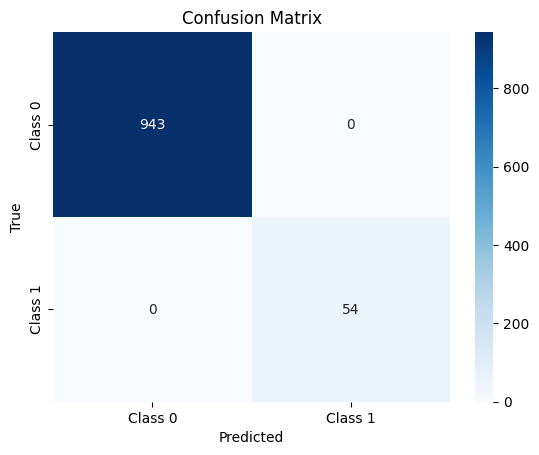

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# a Naive Bayes model (Gaussian Naive Bayes for continuous features)
naive_bayes = GaussianNB()

# Train the model on the training data
naive_bayes.fit(X_train, y_train)

# Make predictions on the test data
y_pred = naive_bayes.predict(X_test)

# Calculate the accuracy of the model
evaluate_model(y_test, y_pred)

In [16]:
""" Coba normalisasi.  Z-Score, MinMAx. untuk langsung dipakai di no 2 yaitu cukup Z score tanpa transformasi normalitas"""

""" Z-Score Normalization """
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_z_array = scaler.fit_transform(features)

# Konversi ke DataFrame agar punya .columns
features_z = pd.DataFrame(features_z_array, columns=feature_names)
features_z.to_csv('/content/drive/MyDrive/Internal-2024/Stroke_z.csv', index=False)

""" Min-Max Normalization """

from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

features_minmax_array = scaler.fit_transform(features)
features_minmax = pd.DataFrame(features_minmax_array, columns=feature_names)
features_minmax.to_csv('/content/drive/MyDrive/Internal-2024/Stroke_minmax.csv', index=False)

In [21]:
"""Splitt data menjadi subset train dan test. Sebagai aturan praktis, rasio 80:20 untuk train dan test.
opsi lain Misalnya, 90:10, atau 70:30. """

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_z, labels, test_size=0.2, random_state=42)

#cek
features_z

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1.183909,1.041887,-0.326186,4.136753,0.720137,-0.351534,0.983473,2.723494,1.193238,-0.353933
1,1.183909,1.615866,-0.326186,4.136753,0.720137,-0.351534,-1.016804,-0.000689,0.589390,0.578840
2,-0.844660,0.247147,-0.326186,-0.241735,0.720137,-0.351534,0.983473,1.448496,0.869222,1.511613
3,-0.844660,1.571713,3.065738,-0.241735,0.720137,0.811143,-1.016804,1.512623,-0.662492,0.578840
4,1.183909,1.660018,-0.326186,-0.241735,0.720137,-0.351534,0.983473,1.780892,0.073909,-0.353933
...,...,...,...,...,...,...,...,...,...,...
4976,1.183909,-0.106071,-0.326186,-0.241735,-1.388624,-0.351534,-1.016804,-0.794401,0.191733,-0.353933
4977,1.183909,-0.150223,-0.326186,-0.241735,0.720137,-0.351534,0.983473,1.890507,0.383197,1.511613
4978,-0.844660,0.070538,3.065738,-0.241735,0.720137,-1.514212,-1.016804,-0.242553,0.486294,1.511613
4979,1.183909,-0.150223,-0.326186,-0.241735,0.720137,-0.351534,-1.016804,-0.488410,0.221189,1.511613


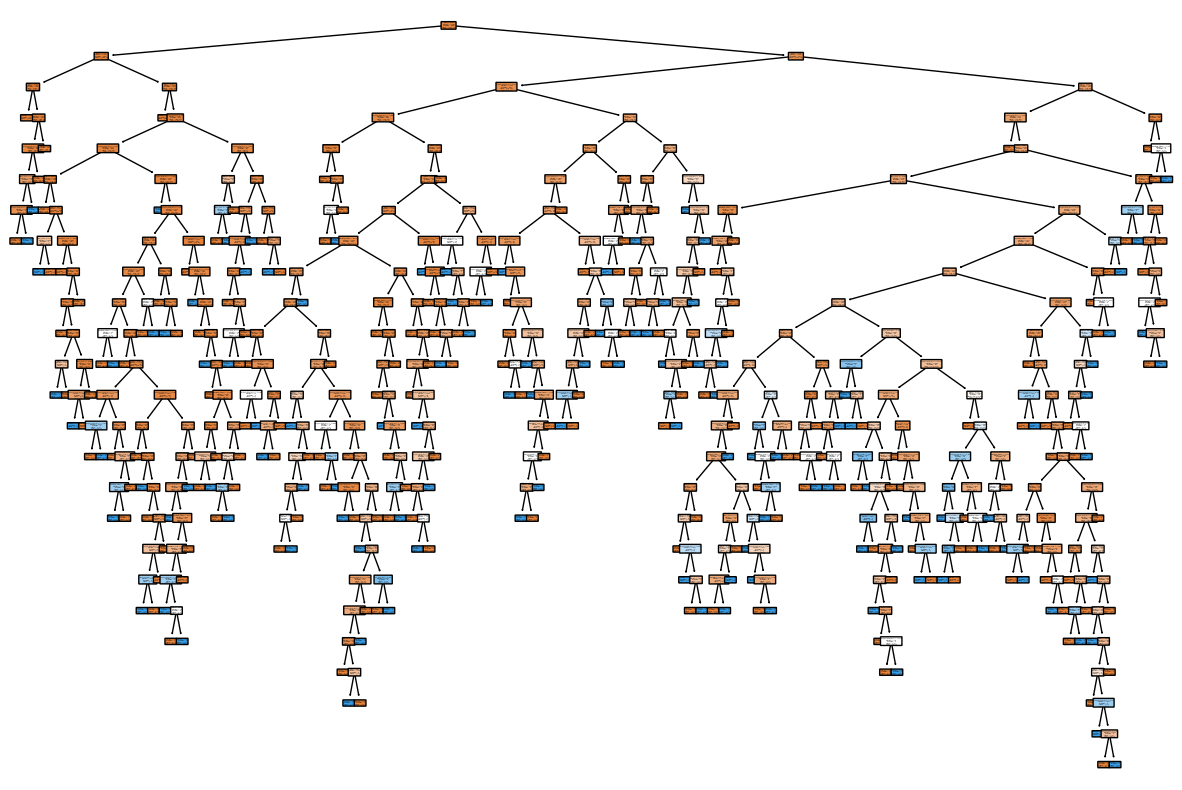

Accuracy: 0.91
Precision: 0.90
Recall: 0.91
F1 Score: 0.91


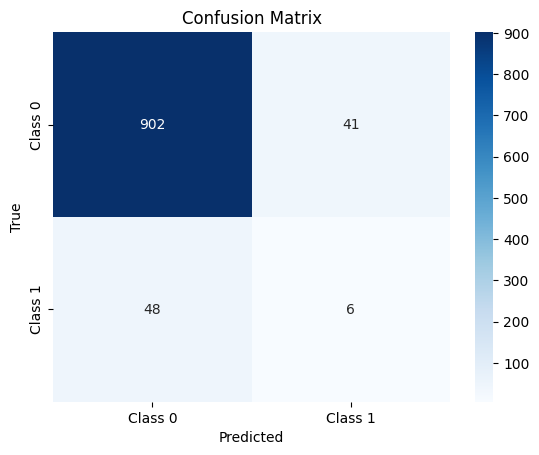

In [25]:
""" Modeling- DecisionTreeClassifier"""

from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ID3 Decision Tree Classifier
id3_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Train the model on the training data
id3_classifier.fit(X_train, y_train)


# Visualisasi pohon keputusan
plt.figure(figsize=(15, 10))
plot_tree(id3_classifier, feature_names=feature_names, class_names=["Class 0", "Class 1"], filled=True, rounded=True)
plt.show()


# Make predictions on the test data
y_pred = id3_classifier.predict(X_test)

# Evaluate the model's accuracy on the test data
evaluate_model(y_test, y_pred)

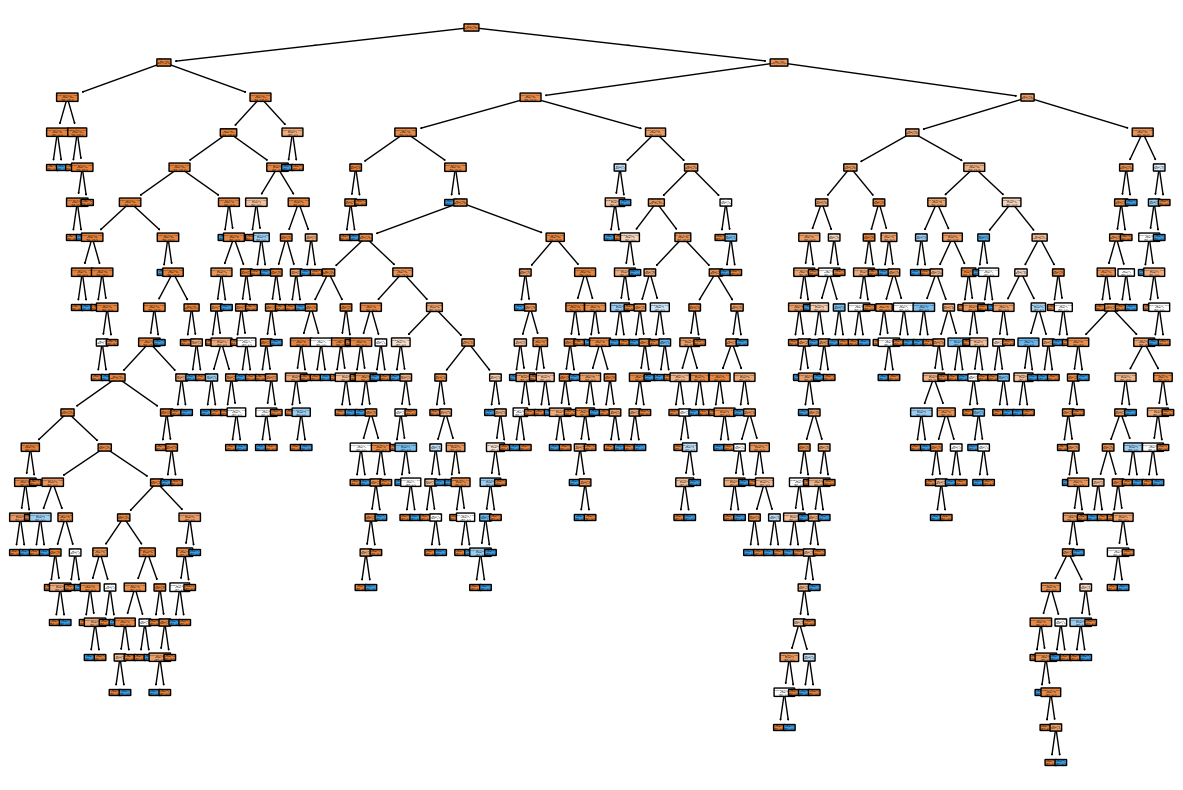

Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1 Score: 0.90


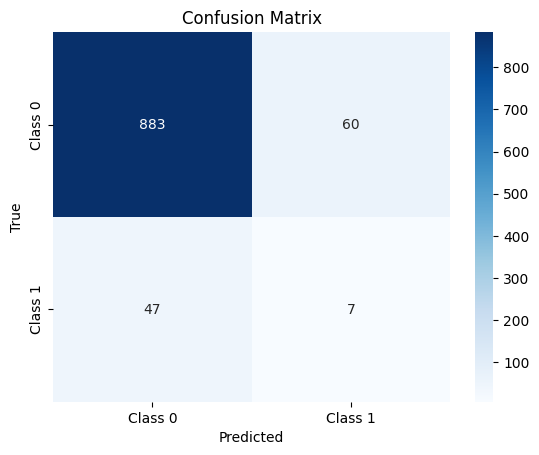

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# CART (C4.5-like) Decision Tree Classifier
c45_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)

# Train the model on the training data
c45_classifier.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(c45_classifier, feature_names=X_train.columns, class_names=["Class 0", "Class 1"], filled=True, rounded=True)
plt.show()

# Make predictions on the test data
y_pred = c45_classifier.predict(X_test)

# Evaluate the model's accuracy on the test data
evaluate_model(y_test, y_pred)

Accuracy: 0.86
Precision: 0.93
Recall: 0.86
F1 Score: 0.89


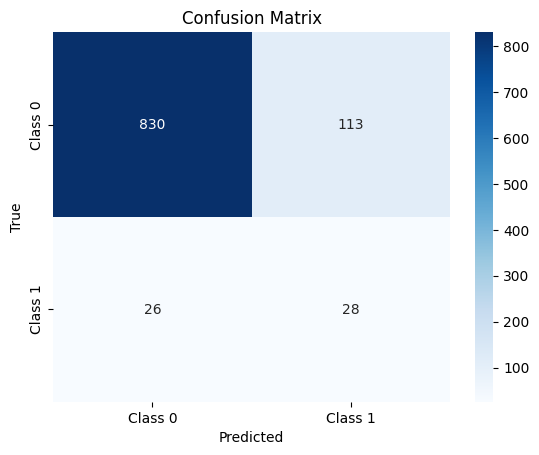

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# a Naive Bayes model (Gaussian Naive Bayes for continuous features)
naive_bayes = GaussianNB()

# Train the model on the training data
naive_bayes.fit(X_train, y_train)

# Make predictions on the test data
y_pred = naive_bayes.predict(X_test)

# Calculate the accuracy of the model
evaluate_model(y_test, y_pred)

Accuracy: 0.95
Precision: 0.89
Recall: 0.95
F1 Score: 0.92


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


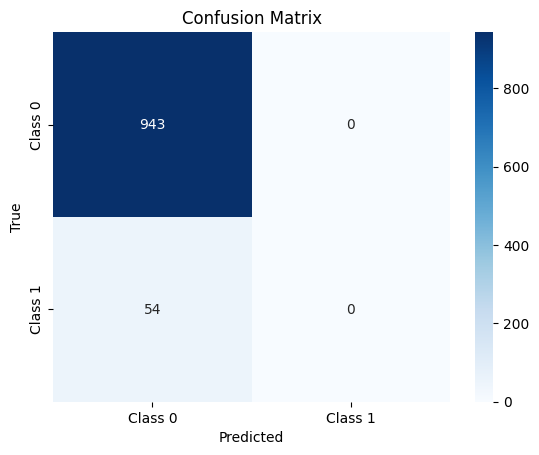

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVM model
svm = SVC(kernel='linear', C=1)

# Train the model on the training data
svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the model
evaluate_model(y_test, y_pred)

Accuracy: 0.93
Precision: 0.89
Recall: 0.93
F1 Score: 0.91


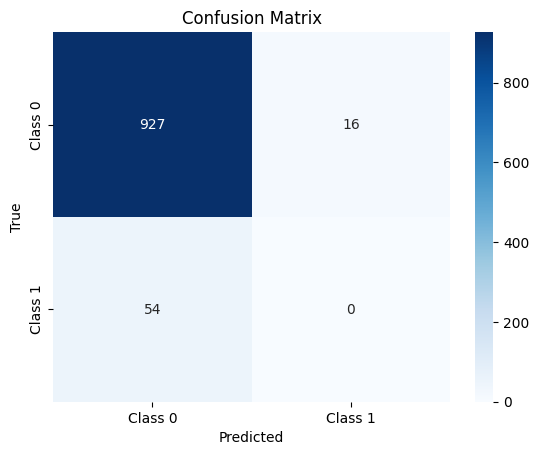

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# KNN model with k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model on the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
evaluate_model(y_test, y_pred)

Accuracy: 0.95
Precision: 0.89
Recall: 0.95
F1 Score: 0.92


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


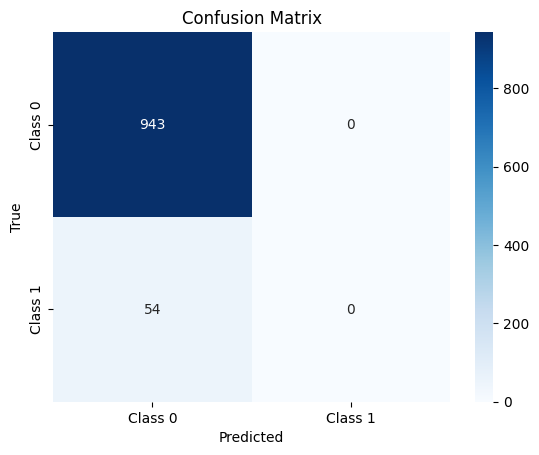

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model
logistic_regression = LogisticRegression()

# Train the model on the training data
logistic_regression.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)

# Calculate the accuracy of the model
evaluate_model(y_test, y_pred)